# STB600 Credit Piece Detection - Workbook

This notebook demonstrates the image processing pipeline for detecting and decoding colored Starwars Credits.

All core functionality is imported from the `stb600_lib` library.

## 1. Imports & Setup

In [1]:
# Core dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Import from local library
from stb600_lib import (
    # IO
    load_source_cv2,
    # Display
    show_image,
    annotate_part_result,
    draw_labeled_contours_colored,
    draw_horizontal_rois_from_boundaries,
    resize_to_screen,
    make_row,
    make_grid,
    # Color processing
    remove_color_hsv,
    detect_piece_color_and_check_size,
    detect_color_parts,
    # Morphology
    binarize_and_invert,
    apply_morphological_opening,
    apply_morphological_closing,
    # Contours
    find_and_draw_contours_with_area_limits,
    extract_contour_features,
    label_contour_by_extent_and_area,
    crop_and_align_vertical,
    # ROI
    split_fixed_horizontal_rois_and_count,
    # Decoding
    decode_roi_to_number,
    compute_total_value_from_rois,
    # Transforms
    rotate_if_marker_bottom,
    # Pipeline
    process_piece,
)

print("Library loaded successfully!")

Library loaded successfully!


## 2. Configuration

In [2]:
# Path to test image
IMAGE_PATH = r"C:\Users\pablo\Desktop\HV\PEOJECT\images\frame_at_8s.png"

# Debug mode - show intermediate results
DEBUG = True

# Processing parameters (defaults work well for most cases)
CONFIG = {
    # Green background removal
    "green_color": "green",
    
    # Main contour detection
    "main_min_area": 10_000,
    "main_max_area": 200_000,
    
    # Color-size thresholds for piece classification
    "small_area_max": 90_000,
    "medium_area_max": 130_000,
    
    # Labeling thresholds for inner parts
    "extent_threshold": 0.5,
    "label_small_area_max": 1000,
    "label_medium_area_max": 2100,
}

## 3. Quick Pipeline (Single Function Call)

Loaded: image


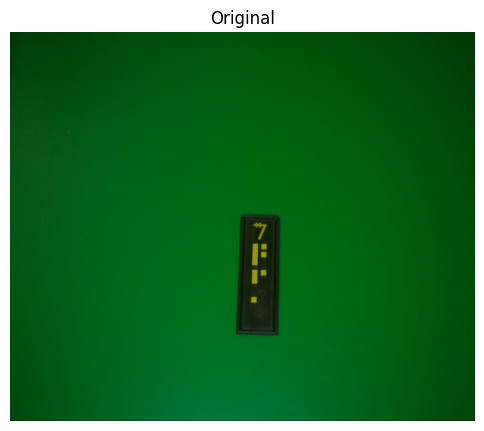

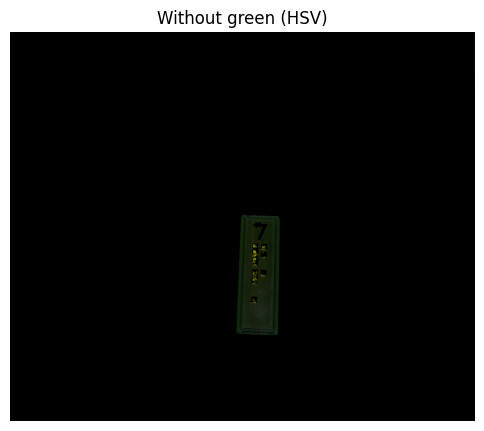

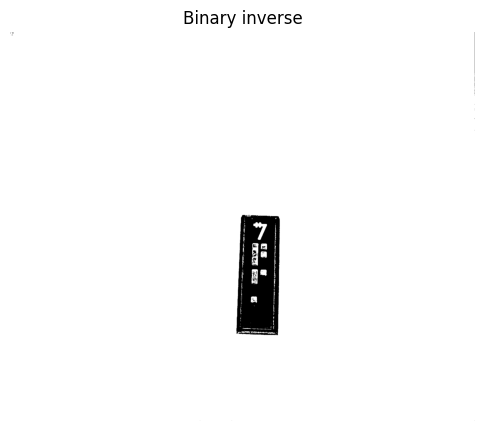

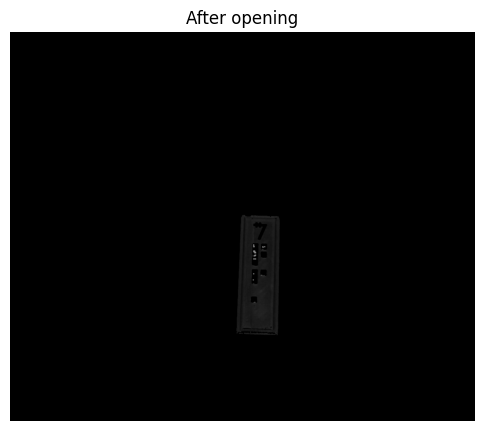

Total contours found: 5
Contours after area filter [10000, 200000]: 1


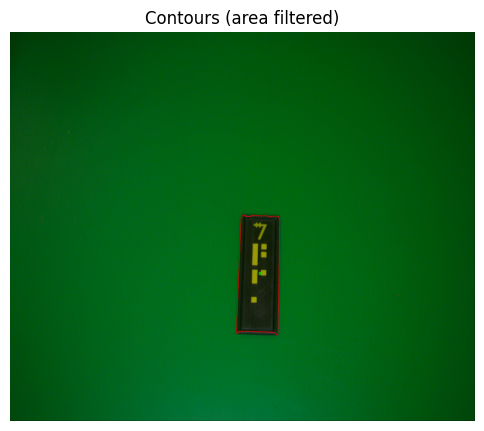

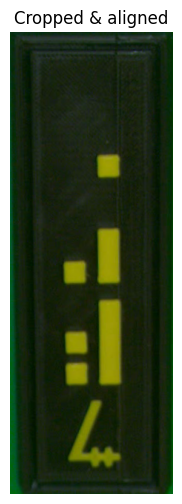

AREA: 128299.0
Piece color: yellow, size: MEDIUM, consistent: True


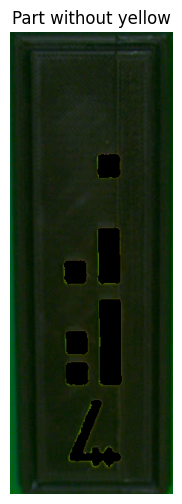

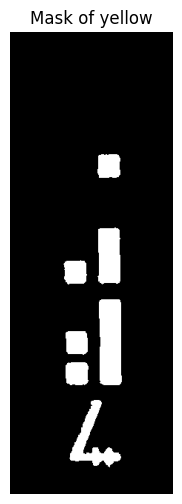

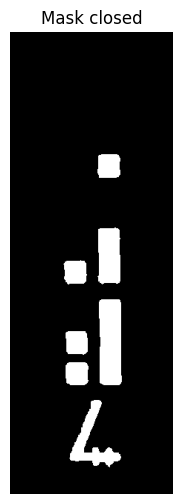

Total contours found: 7
Contours after area filter [100, 200000]: 7


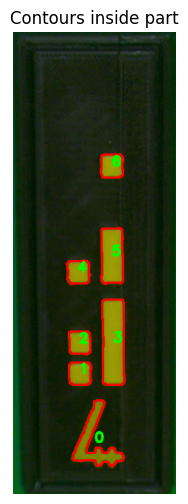

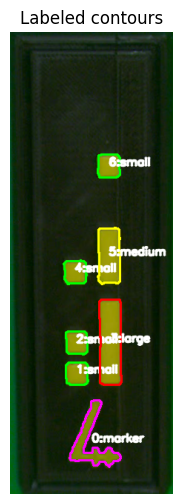

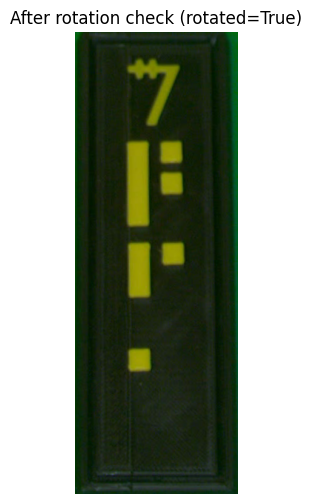

Total contours found: 7
Contours after area filter [100, 200000]: 7


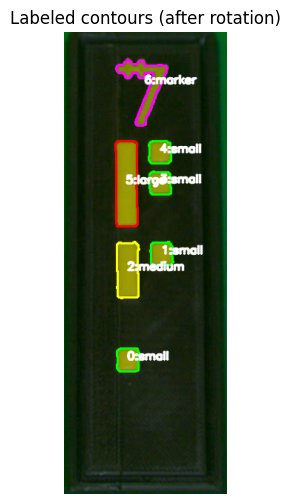

ROI 0 (y: 0-218) -> {'marker': 1, 'small': 2, 'medium': 0, 'large': 1, 'unknown': 0}
ROI 1 (y: 218-436) -> {'marker': 0, 'small': 1, 'medium': 1, 'large': 0, 'unknown': 0}
ROI 2 (y: 436-624) -> {'marker': 0, 'small': 1, 'medium': 0, 'large': 0, 'unknown': 0}


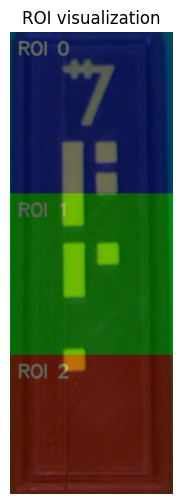

ROI 0 -> digit: 8
ROI 1 -> digit: 4
ROI 2 -> digit: 0
Total value: 8400


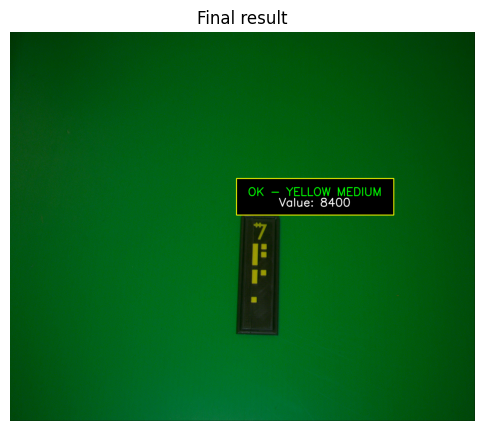


=== RESULTS ===
Piece color: yellow
Size label: MEDIUM
Consistent: True
Total value: 8400
Decoded digits: [8, 4, 0]


In [3]:
# Load image
src_type, img = load_source_cv2(IMAGE_PATH)
print(f"Loaded: {src_type}")

# Run complete pipeline
result = process_piece(img, debug=DEBUG, **CONFIG)

# Show results
print(f"\n=== RESULTS ===")
print(f"Piece color: {result.piece_color}")
print(f"Size label: {result.size_label}")
print(f"Consistent: {result.is_consistent}")
print(f"Total value: {result.total_value}")
print(f"Decoded digits: {result.decoded_digits}")

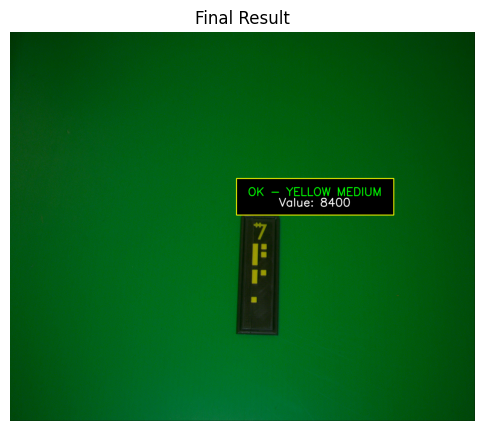

In [4]:
# Display final annotated result
show_image(result.annotated_image, "Final Result")

## 4. Step-by-Step Processing (For Exploration/Debugging)

Use these cells to inspect individual steps of the pipeline.

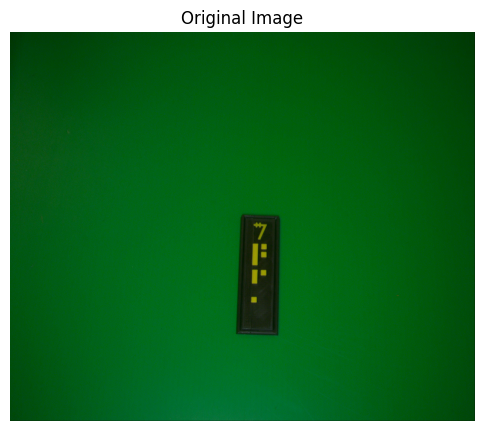

In [5]:
# Step 1: Load image
src_type, img = load_source_cv2(IMAGE_PATH)
show_image(img, "Original Image")

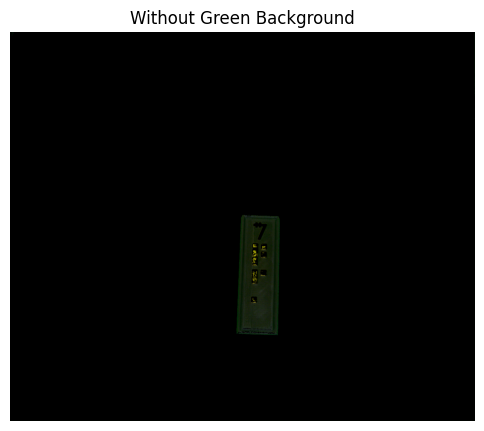

In [6]:
# Step 2: Remove green background
no_green, green_mask = remove_color_hsv(img, "green")
show_image(no_green, "Without Green Background")

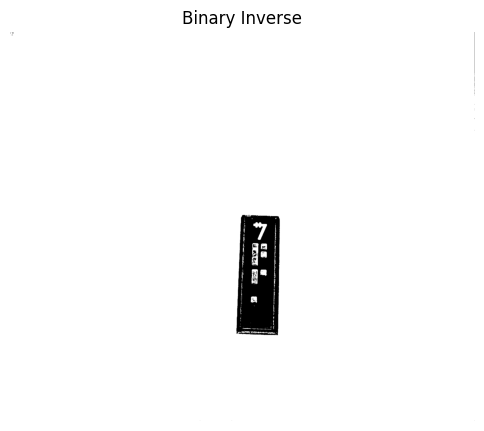

In [7]:
# Step 3: Binarize
gray, binary_inv = binarize_and_invert(no_green)
show_image(cv2.cvtColor(binary_inv, cv2.COLOR_GRAY2BGR), "Binary Inverse")

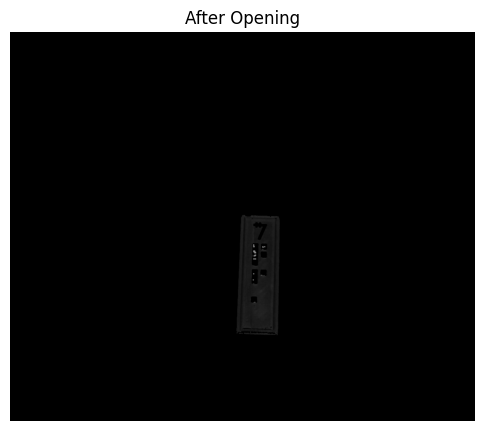

In [8]:
# Step 4: Morphological opening
gray_opened = apply_morphological_opening(gray, kernel_size=(5, 5), iterations=1)
show_image(cv2.cvtColor(gray_opened, cv2.COLOR_GRAY2BGR), "After Opening")

Total contours found: 5
Contours after area filter [10000, 200000]: 1


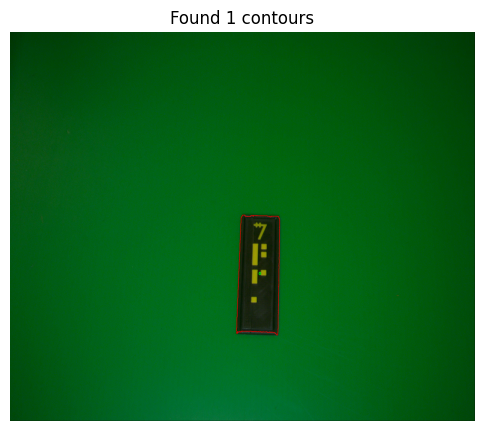

In [9]:
# Step 5: Find main contours
contours, contour_img = find_and_draw_contours_with_area_limits(
    binary_img=gray_opened,
    original_bgr=img,
    min_area=CONFIG["main_min_area"],
    max_area=CONFIG["main_max_area"]
)
show_image(contour_img, f"Found {len(contours)} contours")

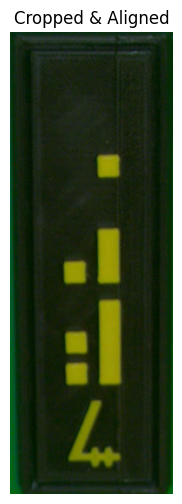

In [10]:
# Step 6: Get main contour and crop/align
main_cnt = max(contours, key=cv2.contourArea)
cropped_aligned = crop_and_align_vertical(img, main_cnt)
show_image(cropped_aligned, "Cropped & Aligned")

In [11]:
# Step 7: Detect piece color
piece_color, size_label, is_consistent, color_counts = detect_piece_color_and_check_size(
    img_bgr=img,
    contour=main_cnt,
    small_area_max=CONFIG["small_area_max"],
    medium_area_max=CONFIG["medium_area_max"],
)
print(f"Piece color: {piece_color}")
print(f"Size label: {size_label}")
print(f"Color consistent: {is_consistent}")
print(f"Color counts: {color_counts}")

Piece color: yellow
Size label: MEDIUM
Color consistent: True
Color counts: {'blue': 2, 'yellow': 10813, 'red': 0}


Total contours found: 7
Contours after area filter [100, 200000]: 7


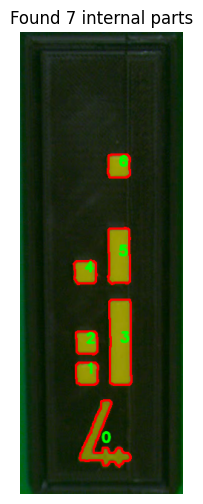

In [12]:
# Step 8: Detect internal parts
part_contours, part_contour_img, mask_closed = detect_color_parts(
    cropped_aligned, piece_color, debug=False
)
show_image(part_contour_img, f"Found {len(part_contours)} internal parts")

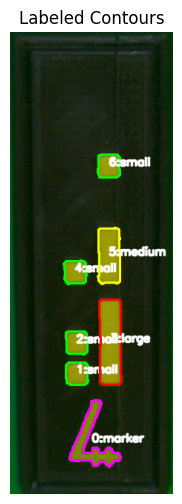

Contour 0: marker (area=1888, extent=0.30)
Contour 1: small (area=843, extent=0.88)
Contour 2: small (area=828, extent=0.86)
Contour 3: large (area=3224, extent=0.90)
Contour 4: small (area=841, extent=0.80)
Contour 5: medium (area=2055, extent=0.86)
Contour 6: small (area=870, extent=0.88)


In [13]:
# Step 9: Extract features and label contours
features_list = extract_contour_features(part_contours)

for f in features_list:
    f["label"] = label_contour_by_extent_and_area(
        f,
        extent_threshold=CONFIG["extent_threshold"],
        small_area_max=CONFIG["label_small_area_max"],
        medium_area_max=CONFIG["label_medium_area_max"]
    )

# Display labeled contours
labeled_img = draw_labeled_contours_colored(
    cropped_aligned, part_contours, features_list,
    extent_threshold=CONFIG["extent_threshold"],
    small_area_max=CONFIG["label_small_area_max"],
    medium_area_max=CONFIG["label_medium_area_max"]
)
show_image(labeled_img, "Labeled Contours")

# Print labels
for f in features_list:
    print(f"Contour {f['index']}: {f['label']} (area={f['area']:.0f}, extent={f['extent']:.2f})")

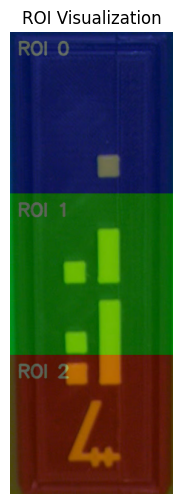

ROI 0 (y: 0-218): {'marker': 0, 'small': 1, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 1 (y: 218-436): {'marker': 0, 'small': 2, 'medium': 1, 'large': 1, 'unknown': 0}
ROI 2 (y: 436-624): {'marker': 1, 'small': 1, 'medium': 0, 'large': 0, 'unknown': 0}


In [14]:
# Step 10: Compute ROIs and decode values
rois, boundaries = split_fixed_horizontal_rois_and_count(
    image_shape=cropped_aligned.shape,
    features_list=features_list,
    piece_color=piece_color,
)

# Visualize ROIs
roi_vis = draw_horizontal_rois_from_boundaries(cropped_aligned, boundaries, alpha=0.3)
show_image(roi_vis, "ROI Visualization")

# Print ROI counts
for r in rois:
    print(f"ROI {r['index']} (y: {r['y_start']}-{r['y_end']}): {r['counts']}")

In [15]:
# Step 11: Decode digits from ROI counts
decoded_digits = []
for r in rois:
    try:
        digit = decode_roi_to_number(r["counts"])
        decoded_digits.append(digit)
        print(f"ROI {r['index']} -> digit: {digit}")
    except ValueError as e:
        print(f"ROI {r['index']} -> ERROR: {e}")
        decoded_digits.append(None)

# Compute total value
total_value = compute_total_value_from_rois(decoded_digits, piece_color)
print(f"\nTotal value: {total_value}")

ROI 0 -> digit: 0
ROI 1 -> ERROR: Invalid combination for a digit: {'marker': 0, 'small': 2, 'medium': 1, 'large': 1, 'unknown': 0}
ROI 2 -> digit: 0

Total value: 0


## 5. Batch Processing Multiple Images

In [16]:
# Process all test images
import os

image_folder = r"C:\Users\pablo\Desktop\HV\PEOJECT\images"
results = []

for filename in os.listdir(image_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        filepath = os.path.join(image_folder, filename)
        print(f"\nProcessing: {filename}")
        
        try:
            _, img = load_source_cv2(filepath)
            result = process_piece(img, debug=False)
            
            results.append({
                "file": filename,
                "color": result.piece_color,
                "size": result.size_label,
                "consistent": result.is_consistent,
                "value": result.total_value,
            })
            print(f"  -> {result.piece_color} {result.size_label}: value={result.total_value}")
            
        except Exception as e:
            print(f"  -> ERROR: {e}")

print("\n=== Summary ===")
for r in results:
    print(f"{r['file']}: {r['color']} {r['size']} = {r['value']} (consistent={r['consistent']})")


Processing: frame_at_11s.png
Total contours found: 2
Contours after area filter [10000, 200000]: 1
Total contours found: 6
Contours after area filter [100, 200000]: 6
  -> red SMALL: value=42

Processing: frame_at_13.5s.png
Total contours found: 2
Contours after area filter [10000, 200000]: 2
Total contours found: 7
Contours after area filter [100, 200000]: 7
  -> blue BIG: value=940

Processing: frame_at_24s.png
Total contours found: 4
Contours after area filter [10000, 200000]: 3
Total contours found: 6
Contours after area filter [100, 200000]: 6
  -> red SMALL: value=16

Processing: frame_at_27.75s.png
Total contours found: 5
Contours after area filter [10000, 200000]: 4
Total contours found: 10
Contours after area filter [100, 200000]: 10
Total contours found: 10
Contours after area filter [100, 200000]: 10
  -> yellow MEDIUM: value=5520

Processing: frame_at_6.5s.png
Total contours found: 1
Contours after area filter [10000, 200000]: 1
Total contours found: 8
Contours after area 

## 6. Create Comparison Grid

Total contours found: 2
Contours after area filter [10000, 200000]: 1
Total contours found: 6
Contours after area filter [100, 200000]: 6
Total contours found: 2
Contours after area filter [10000, 200000]: 2
Total contours found: 7
Contours after area filter [100, 200000]: 7
Total contours found: 4
Contours after area filter [10000, 200000]: 3
Total contours found: 6
Contours after area filter [100, 200000]: 6
Total contours found: 5
Contours after area filter [10000, 200000]: 4
Total contours found: 10
Contours after area filter [100, 200000]: 10
Total contours found: 10
Contours after area filter [100, 200000]: 10
Total contours found: 1
Contours after area filter [10000, 200000]: 1
Total contours found: 8
Contours after area filter [100, 200000]: 7
Total contours found: 1
Contours after area filter [10000, 200000]: 1
Total contours found: 8
Contours after area filter [100, 200000]: 7
Total contours found: 5
Contours after area filter [10000, 200000]: 1
Total contours found: 7
Contou

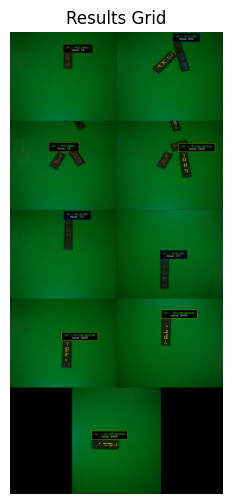

In [17]:
# Create a grid of annotated results
import os

image_folder = r"C:\Users\pablo\Desktop\HV\PEOJECT\images"
annotated_images = []

for filename in os.listdir(image_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        filepath = os.path.join(image_folder, filename)
        try:
            _, img = load_source_cv2(filepath)
            result = process_piece(img, debug=False)
            annotated_images.append(resize_to_screen(result.annotated_image, 400, 400))
        except Exception:
            pass

# Create grid (2 images per row)
rows = []
for i in range(0, len(annotated_images), 2):
    row_imgs = annotated_images[i:i+2]
    if row_imgs:
        rows.append(make_row(row_imgs))

if rows:
    grid = make_grid(rows)
    show_image(grid, "Results Grid")

---

## 7. Interactive GUI Application

The library includes an interactive Tkinter GUI for parameter tuning and real-time camera processing.

### GUI Tabs Overview

The GUI provides the following interactive tabs for parameter tuning:

| Tab | Description |
|-----|-------------|
| **0) Input** | Load images or toggle camera, select piece color |
| **1) Remove green** | Adjust HSV thresholds for background removal |
| **2) Binarize** | Adjust binarization threshold |
| **3) Opening** | Tune morphological opening kernel and iterations |
| **4) Big contours** | Filter contours by area thresholds |
| **4b) Cropped main** | View cropped and aligned main piece |
| **5) Inner parts** | Detect internal colored parts |
| **6) Labeled** | Label parts as marker/small/medium/large + rotation if needed|
| **7) ROIs** | Define ROI regions and count parts |

Each tab shows real-time results as you adjust the sliders.

In [23]:
# Import the GUI module
from stb600_lib.gui import run_pipeline_gui, PipelineApp

# Launch the interactive pipeline GUI with an initial image
# Uncomment and run to start:

run_pipeline_gui(use_camera=True)

# Or with camera enabled:
# run_pipeline_gui(use_camera=True)

# Or without any initial image (use "Load image" button in GUI):
# run_pipeline_gui()

In [24]:
# Import and run the Result Viewer
from stb600_lib.gui import run_result_viewer

# Launch the result viewer GUI
# This opens a window where you can:
# - Load an image with the "Load Image" button
# - The pipeline runs automatically
# - See the detected color, size, and VALUE
# - Bounding box is drawn around the detected piece

run_result_viewer()

## 5. Video Processor - Tracking & Counting

Process videos or live camera feed with object tracking to count unique pieces.

| Feature | Description |
|---------|-------------|
| **Load Video** | Load a video file (MP4, AVI, MOV) |
| **Start Camera** | Use live camera feed |
| **Counting Line** | Pieces are counted when crossing this line |
| **Object Tracking** | Norfair library tracks pieces across frames |
| **Running Total** | Accumulated value of all counted pieces |

**Requirements:** `pip install norfair` for object tracking.

In [20]:
# Import and run the Video Processor
from stb600_lib.gui import run_video_processor

# Launch the video processor GUI
# This opens a window where you can:
# - Load a video file OR start live camera feed
# - Play/Pause/Stop video playback
# - Adjust counting line position (H=horizontal, V=vertical)
# - See pieces tracked with bounding boxes and IDs
# - Pieces are counted when crossing the counting line
# - Running total displayed in real-time
# - Reset count button to start over

run_video_processor()

In [21]:
# DIAGNOSTIC v2: Use actual config parameters
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# Load config
with open("pipeline_config.json", "r") as f:
    config = json.load(f)

shared = config["shared"]
rg = shared["remove_green"]
op = shared["opening"]

print(f"Config: h_low={rg['h_low']}, h_high={rg['h_high']}")
print(f"Opening: kernel={op['kernel_size']}, iterations={op['iterations']}")

# Custom green removal using YOUR config parameters
def remove_green_with_config(img, h_low, h_high):
    """Remove green using specific HSV range from config."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Create mask for green
    lower = np.array([h_low, 40, 40])
    upper = np.array([h_high, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    # Replace green with white
    result = img.copy()
    result[mask > 0] = [255, 255, 255]
    return result, mask

from stb600_lib import binarize_and_invert, apply_morphological_opening

# Load images
img_vertical = cv2.imread("images/blue.png")
img_diagonal = cv2.imread("images/blue_sideways.png")

def analyze_piece_v2(img, name, h_low, h_high, kernel_size, iterations):
    """Analyze using actual config parameters."""
    print(f"\n=== {name} ===")
    
    # Step 1: Remove green with CONFIG parameters
    no_green, mask = remove_green_with_config(img, h_low, h_high)
    
    # Step 2: Binarize
    _, binary_raw = binarize_and_invert(no_green, threshold_value=0)
    
    # Step 3: Morphological opening with CONFIG parameters
    binary_opened = apply_morphological_opening(
        binary_raw, 
        kernel_size=(kernel_size, kernel_size), 
        iterations=iterations
    )
    
    # Find contours
    contours, _ = cv2.findContours(binary_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Filter to reasonable size (not the whole image)
        valid = [c for c in contours if 100000 < cv2.contourArea(c) < 1000000]
        if valid:
            main = max(valid, key=cv2.contourArea)
            area = cv2.contourArea(main)
            x, y, w, h = cv2.boundingRect(main)
            print(f"Area: {area:,.0f} px")
            print(f"Bounding box: {w} x {h} = {w*h:,} px")
            print(f"Fill ratio: {area/(w*h):.2%}")
            return binary_opened, main, area
        else:
            print("No valid contours found!")
            # Show what WAS found
            for i, c in enumerate(contours[:5]):
                print(f"  Contour {i}: area={cv2.contourArea(c):,.0f}")
    
    return binary_opened, None, 0

# Analyze both
b1, c1, area1 = analyze_piece_v2(img_vertical, "VERTICAL", rg['h_low'], rg['h_high'], op['kernel_size'], op['iterations'])
b2, c2, area2 = analyze_piece_v2(img_diagonal, "DIAGONAL", rg['h_low'], rg['h_high'], op['kernel_size'], op['iterations'])

# Calculate difference
if area1 > 0 and area2 > 0:
    diff_pct = abs(area1 - area2) / min(area1, area2) * 100
    print(f"\n=== COMPARISON ===")
    print(f"Difference: {abs(area1-area2):,.0f} px ({diff_pct:.1f}%)")

# Show images
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(b1, cmap='gray')
axes[0].set_title(f"Vertical: {area1:,.0f} px")
axes[1].imshow(b2, cmap='gray')
axes[1].set_title(f"Diagonal: {area2:,.0f} px")
plt.tight_layout()
plt.show()

Config: h_low=58, h_high=75
Opening: kernel=1, iterations=1

=== VERTICAL ===


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
